In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

matplotlib.rc("axes", **{"spines.top": False, "spines.right": False})
matplotlib.rc("legend", frameon=False)

In [9]:
df = (pd.read_json("../results/measure_speed.jsonl", lines=True)
    .pipe(lambda d: d.assign(
        input_mode=d.n_inner_inputs.apply(lambda x: "small" if x == 1 else "large"),
        compile=d.compile.fillna("eager"),
        method=d.method.apply(lambda s: re.sub(r"(^\.+)|(\.+$)", "", re.sub(r"\b(approx_topk|exact_methods|topk|__main__)\b", "", s))),
        duration=d.duration.apply(np.mean) / d.n_inner,
        duration_stderr=d.duration.apply(lambda d: np.std(d)/np.sqrt(len(d))) / d.n_inner,
    ))
    .pipe(lambda d: d.assign(
        bandwidth=d.dtype.apply(dict(float32=4, float16=2).__getitem__) * d.topk_size * d.batch_size / d.duration,
    ))
)
df.head()

,compile,cuda_graphs,batch_size,topk_size,k,n_warmup,n_outer,n_inner,n_inner_inputs,method,dtype,duration,device,block_size,input_mode,duration_stderr,bandwidth
0,eager,True,32,4096,512,16,16,128,NaN,fake_topk_sum,float16,0.000015,NVIDIA A10G,NaN,large,1.996105e-09,1.726847e+10
1,eager,True,32,16384,2048,16,16,128,NaN,fake_topk_sum,float16,0.000007,NVIDIA A10G,NaN,large,2.546430e-09,1.523097e+11
2,eager,True,32,65536,8192,16,16,128,NaN,fake_topk_sum,float16,0.000017,NVIDIA A10G,NaN,large,3.000023e-09,2.532792e+11
3,eager,True,32,4096,512,16,16,128,NaN,torch_default,float16,0.000028,NVIDIA A10G,NaN,large,6.398291e-09,9.393485e+09
4,eager,True,32,16384,2048,16,16,128,NaN,torch_default,float16,0.000041,NVIDIA A10G,NaN,large,9.116397e-09,2.551435e+10


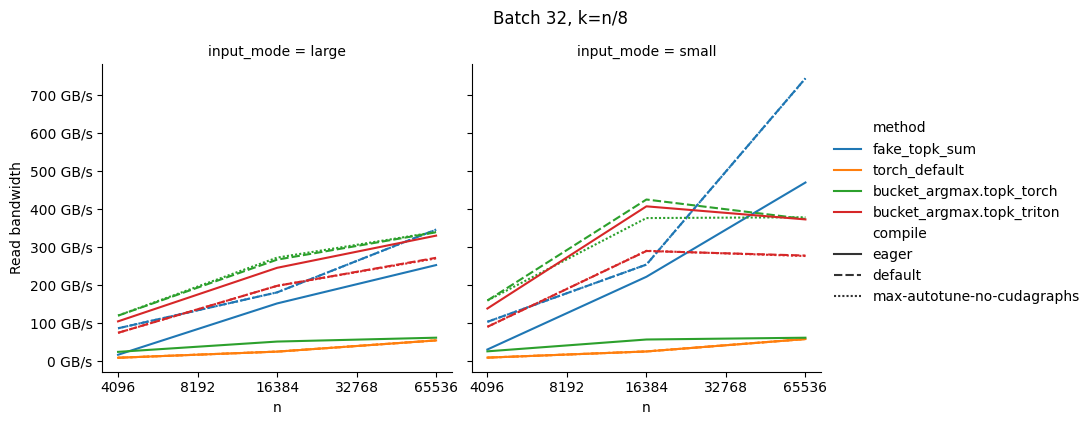

In [22]:
batch_size, = df.batch_size.unique()
topk_size_over_k, = (df.topk_size//df.k).unique()

g = sns.relplot(data=df, y="bandwidth", x="topk_size", hue="method", col="input_mode", style="compile", kind="line", height=4)
for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_xlabel("n")
    ax.set_ylabel("Read bandwidth")
plt.suptitle(f"Batch {batch_size}, k=n/{topk_size_over_k}", y=1.05);

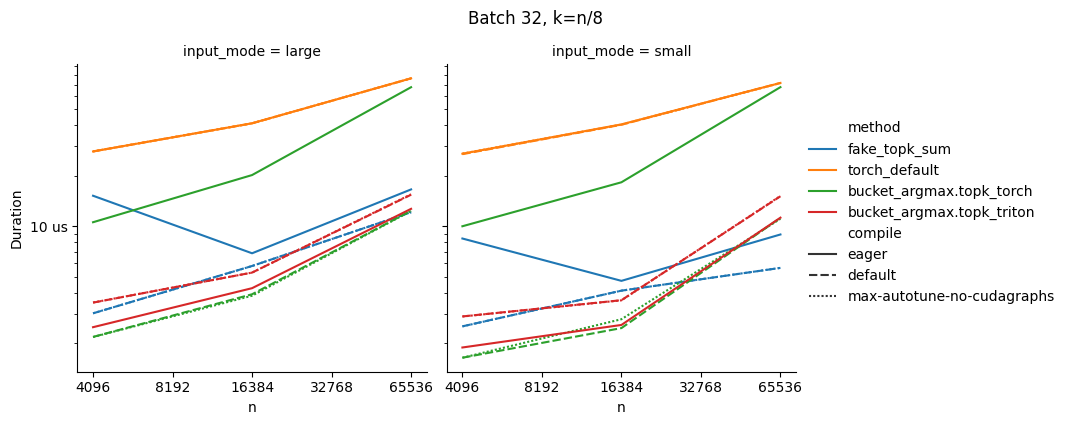

In [20]:
g = sns.relplot(data=df, y="duration", x="topk_size", hue="method", col="input_mode", style="compile", kind="line", height=4)
for ax in g.axes.flatten():
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(lambda x, _: f"{x*1e6:.0f} us")
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_xlabel("n")
    ax.set_ylabel("Duration")
plt.suptitle(f"Batch {batch_size}, k=n/{topk_size_over_k}", y=1.05);